# **SIADS Milestone I**

- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **Yao Tong (tonyao@umich.edu)**, School of Information, University of Michigan



#### **Strcuture of the Code:**

##### **Data Import**
##### **Data Cleaning & Manipulation**
&emsp; 1. Basic Desciptive Statistic Data Manipulation<br>
&emsp; 2. Music Related Data Manipulation<br>
&emsp; 3. Author Related Data Manipulation<br>
&emsp; 4. Video Related Data Manipulation<br>
&emsp; 5. Test Related Data Manipulation<br>
##### **Data Analysis & Visualisation**
&emsp; 1. Basic Desciptive Statistic Analysis<br>
&emsp; 2. Music Related Analysis<br>
&emsp; 3. Author Related Analysis<br>
&emsp; 4. Video Related Analysis<br>
&emsp; 5. Test Related Analysis<br>

In [1]:
import sys, os
import json
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import itertools
import nltk
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import pearsonr
from boto3.dynamodb.types import TypeDeserializer
sys.path.append(os.getcwd() + "/src")
from src.pj_config.dynamo_db_client import get_dynamo_db_client
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial Unicode MS'

# **Data Import**

The trending.json was initially imported into DynamoDB and retrived by the scan() method from boto3.

The following code aims to convert a response from a DynamoDB scan operation into a Pandas DataFrame. Initially, it retrieves items from the DynamoDB table 'tiktok_trending' using the scan operation. To handle cases where the result spans multiple pages, it iterates through each page, continuously appending the retrieved items.

The convert_dynamodb_response function plays a crucial role in converting the raw DynamoDB response into a DataFrame. It first defines a deserializer to handle data types, then parses each item in the response to convert it into a dictionary. This dictionary comprehension ensures that the data is deserialized appropriately. Subsequently, any dictionary values are further processed to extract their string representations. Finally, these processed items are converted into a DataFrame, providing a structured representation of the DynamoDB data suitable for analysis and manipulation in Python.

In [2]:
def convert_dynamodb_response(response):
    deserializer = TypeDeserializer()
    def parse_item(item):
        return {key: deserializer.deserialize(value) for key, value in item.items()}
  
    items_temp = [parse_item(item) for item in items]
    df = pd.DataFrame(items_temp)
    df = df.applymap(lambda x: x if not isinstance(x, dict) else x.get('S', x))
    return df
    
dynamodb = get_dynamo_db_client()
response = dynamodb.scan(TableName='tiktok_trending')

items=response["Items"]

while 'LastEvaluatedKey' in response and response['LastEvaluatedKey'] != "":  
    response = dynamodb.scan(TableName='tiktok_trending', ExclusiveStartKey=response['LastEvaluatedKey'])
    items.extend(response["Items"])
df = convert_dynamodb_response(items)


# **Data Cleaning & Manipulation**
The part encompasses several data preprocessing steps commonly encountered in exploratory data analysis (EDA) tasks, primarily focusing on structuring data extracted from the TikTok platform for subsequent analysis.

Firstly, it performs basic data preprocessing, including the conversion of specified columns to numeric types and the removal of outliers based on the interquartile range (IQR) method. Subsequently, the code segments the dataset into four distinct categories: user, music, video, and text, each tailored to the nature of the features they encapsulate.

For user-related data, it involves extracting pertinent information about TikTok authors and restructuring it for clarity and ease of analysis. Similarly, for music-related data, it involves processing music metadata and merging it with external data from the AuDD platform, facilitating comprehensive insights into the music used in TikTok content. Video data undergoes a transformation to extract key attributes such as width, duration, and height from the video metadata. Lastly, text-related data are structured to include relevant hashtag information and categorize various engagement metrics into discrete categories.

By segmenting and preprocessing the TikTok dataset into these distinct categories, the code lays the groundwork for subsequent analysis, enabling researchers and analysts to delve deeper into specific aspects of TikTok content and user engagement.

### **1. Basic Desciptive Statistic Data Manipulation**

In [3]:
###### Basic
                          
df = df.copy()
numeric_columns = ['diggCount', 'commentCount', 'shareCount', 'playCount']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

Q1 = df[numeric_columns].quantile(0.05)
Q3 = df[numeric_columns].quantile(0.80)
IQR = Q3 - Q1

def remove_outliers(df):
    return df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
df = remove_outliers(df)

basic_df = df[['id', 'createTime', 'diggCount', 'commentCount', 'shareCount', 'playCount']]

### **2. Music Related Data Manipulation**

In [4]:
###### Music
music_df = df[['id', 'createTime', 'musicMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
music_df = music_df.copy()
music_df['musicMeta'] = music_df['musicMeta'].apply(lambda x: {
    'musicId': x['musicId'],
    'musicAuthor': x['musicAuthor'],
    'musicName': x['musicName'],
    'musicOriginal': x['musicOriginal'],
    'playUrl': x['playUrl']
})
music_df[['musicId', 'musicAuthor', 'musicName', 'musicOriginal', 'playUrl']] = pd.DataFrame(music_df['musicMeta'].tolist())
music_df.drop(columns=['musicMeta'], inplace=True)
music_df = music_df.dropna()

music_df['musicId'] = music_df['musicId'].astype('int64')
audd_music_df = pd.read_csv(
    'src/data/audd/audd_music.csv',
    sep=',',  # Specify the delimiter if it's not a comma
    skiprows=1,  # Skip rows if necessary (e.g., skip the first row)
    names=['id', 'artist', 'title','album','release_data','label','timecode','song_link','apple_music.isrc','spotify.id'],  
    encoding='utf-8'  # Specify the encoding if there are special characters
)

merged_music_df = pd.merge(audd_music_df, music_df, left_on='id', right_on='musicId', how='inner')


### **3. Author Related Data Manipulation**

In [5]:
###### User
authors_df = df[['id', 'createTime', 'authorMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
authors_df = authors_df.copy()
authors_df['authorMeta'] = authors_df['authorMeta'].apply(lambda x: {'secUid': x['secUid'], 
                                                               'signature': x['signature'], 
                                                               'nickName': x['nickName'], 
                                                               'name': x['name'], 
                                                               'verified': x['verified'], 
                                                               'id': x['id'], 
                                                               'avatar': x['avatar']})

authors_df[['secUid', 'signature', 'nickName', 'name', 'verified', 'id', 'avatar']] = pd.DataFrame(authors_df['authorMeta'].tolist())
authors_df = authors_df.dropna()

### **4. Video Related Data Manipulation**

In [6]:
###### Video
video_df = df[['id', 'createTime', 'videoMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
video_df = video_df.copy()

# Extract videoMeta into 3 fields(video_width, video_duration and video_height)
video_df['videoMeta'] = video_df['videoMeta'].apply(lambda x: {'width': int(x['width']), 'duration': int(x['duration']), 'height': int(x['height'])})
video_df[['video_width', 'video_duration', 'video_height']] = pd.DataFrame(video_df['videoMeta'].tolist())

video_df = video_df.dropna()

### **5. Test Related Data Manipulation**

In [7]:
###### Text
text_df = df[['id', 'createTime', 'hashtags', 'mentions', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]

categories = ['diggCountCategory', 'shareCountCategory', 'playCountCategory', 'commentCountCategory']
target_values = ['very low', 'low', 'medium', 'high', 'very high']

# Divided diggCount, commentCount, shareCount and playCount into 'very low', 'low', 'medium', 'high', 'very high' 5 catagories
def process_numeric_column(df, column_name):
    df_copy = df.copy()
    quantiles = df_copy[column_name].quantile([0, 1/5, 2/5, 3/5, 4/5, 1])
    df_copy[f'{column_name}Category'] = pd.cut(df_copy[column_name], bins=quantiles, labels=target_values, include_lowest=True)
    return df_copy

text_df = process_numeric_column(text_df, 'diggCount')
text_df = process_numeric_column(text_df, 'commentCount')
text_df = process_numeric_column(text_df, 'shareCount')
text_df = process_numeric_column(text_df, 'playCount')

text_df['hashtag'] = text_df['hashtags'].apply(lambda x: [item['name'] for item in x] if x else [])
text_df = text_df.explode('hashtag').reset_index(drop=True)
text_df = text_df[['id', 'createTime', 'hashtag', 'diggCount', 'commentCount', 'shareCount', 'playCount','diggCountCategory', 'shareCountCategory', 'playCountCategory', 'commentCountCategory']]
text_df = text_df.dropna()

# **Data Analysis & Visualisation**
This part will cover the data analysis and visualization pipeline covering various domains such as music, video, and text. Let's break down each section and understand its purpose and what insights can be derived from the visualizations.

### **1. Basic Desciptive Statistic**

Descriptive Statistics:
          diggCount  commentCount   shareCount      playCount
count    827.000000    827.000000   827.000000     827.000000
mean    9705.031439    175.051995   162.212817  104355.544135
std    11624.474699    217.013570   263.386790  107889.272489
min       13.000000      0.000000     0.000000     465.000000
25%     2201.000000     37.000000    15.000000   41750.000000
50%     5534.000000     91.000000    53.000000   67100.000000
75%    12400.000000    219.500000   176.000000  126200.000000
max    73300.000000   1238.000000  1508.000000  762500.000000


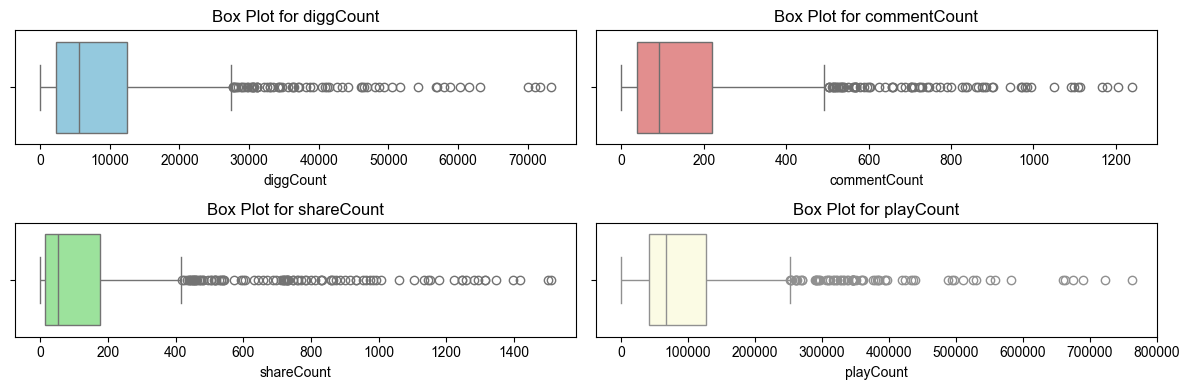

In [8]:
###### Basic
descriptive_stats = basic_df[['diggCount', 'commentCount', 'shareCount', 'playCount']].describe()

print("Descriptive Statistics:")
print(descriptive_stats)

plt.figure(figsize=(12, 4))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']
for i, (col, color) in enumerate(zip(numeric_columns, colors), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=basic_df[col], color=color)
    plt.title(f'Box Plot for {col}')

plt.tight_layout()
plt.show()

### **2. Music Related Analysis**

##### **a. Analyze The Most Used Labels**

This part visualizes the distribution of original and not original music for different labels. It helps in understanding which labels tend to produce more original content.
The scatter plot provides an overview of how originality varies across labels, with the size of the points representing the total number of songs.

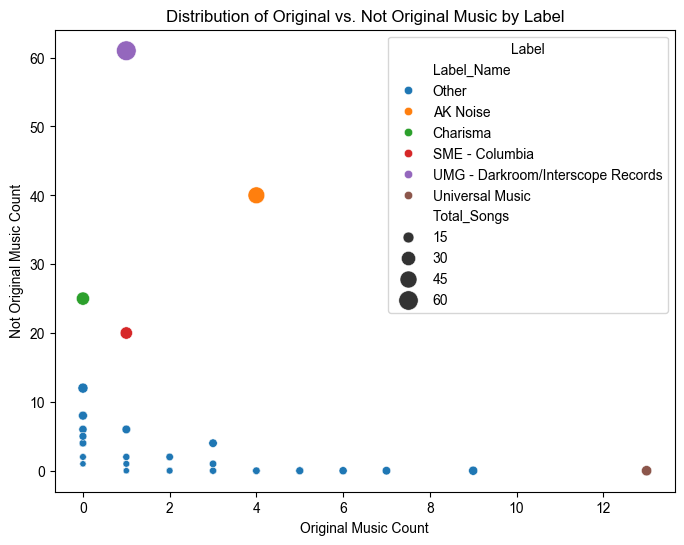

In [9]:
###### Music
# Aggregate data to count original and not original music for each label
agg_data = merged_music_df.groupby('label')['musicOriginal'].value_counts().unstack().fillna(0)
agg_data.columns = ['Not_Original', 'Original']
agg_data['Total_Songs'] = agg_data['Original'] + agg_data['Not_Original']

# Identify the top five labels by total song count
top_five_labels = agg_data['Total_Songs'].nlargest(5).index

# Create a new column 'Label_Name' that contains the label names for the top five and 'Other' for the rest
agg_data['Label_Name'] = agg_data.index.where(agg_data.index.isin(top_five_labels), 'Other')

# Reset index to make 'label' a column if it's not already
agg_data.reset_index(inplace=True)
# Create the chart using 'Label_Name' for color encoding
plt.figure(figsize=(8, 6))  # Set the figure size

# Create the scatter plot
sns.scatterplot(data=agg_data, x='Original', y='Not_Original', size='Total_Songs', hue='Label_Name',
                palette='tab10', sizes=(20, 200), legend='brief')

# Set titles and labels
plt.title('Distribution of Original vs. Not Original Music by Label')
plt.xlabel('Original Music Count')
plt.ylabel('Not Original Music Count')

# Show the plot
plt.legend(title='Label')
plt.show()

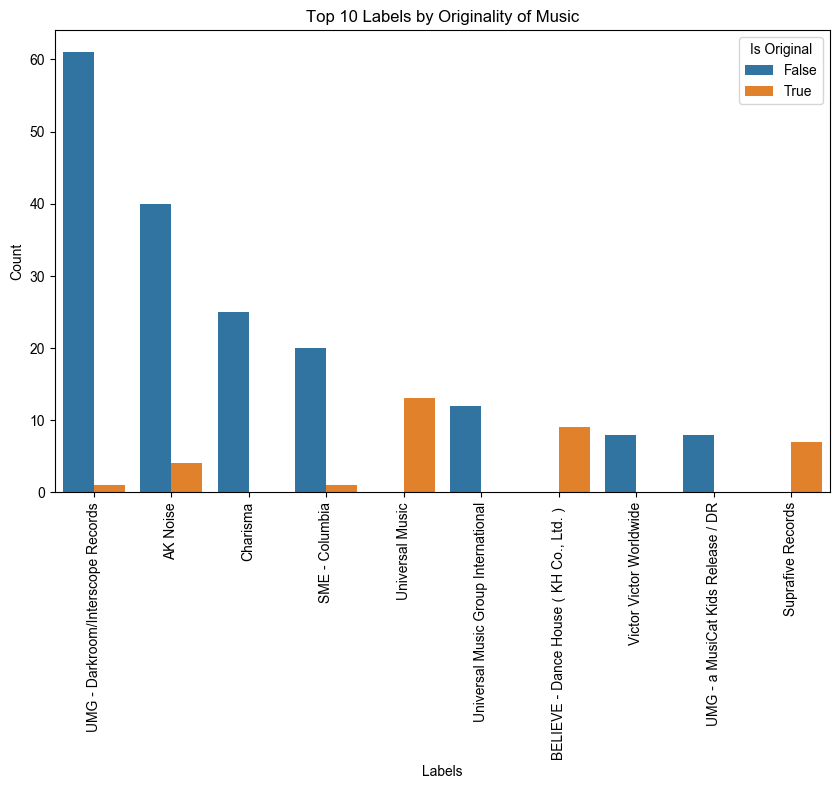

In [10]:
top_10_L = merged_music_df['label'].value_counts().head(10).index

# Filter the DataFrame to include only rows with the top 10 'L' values
filtered_df = merged_music_df[merged_music_df['label'].isin(top_10_L)]

# Create a grouped bar chart with the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(x='label', hue='musicOriginal', data=filtered_df, order=top_10_L)
plt.title('Top 10 Labels by Originality of Music')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.legend(title='Is Original')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()

##### **b. Analyze The Most Frequent Timecode That Trending Videos Will Use In The Musics**

This section explores the density of timecodes for song cuts, providing insights into the distribution of song lengths.
The KDE plot visualizes the distribution of timecodes (in seconds), allowing for the identification of common song durations.

/var/folders/f4/bhm9ydyx22x8b4hg_kwhxhpr0000gn/T/ipykernel_81933/3511141359.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timecode'] = filtered_df['timecode'].apply(timecode_to_seconds)


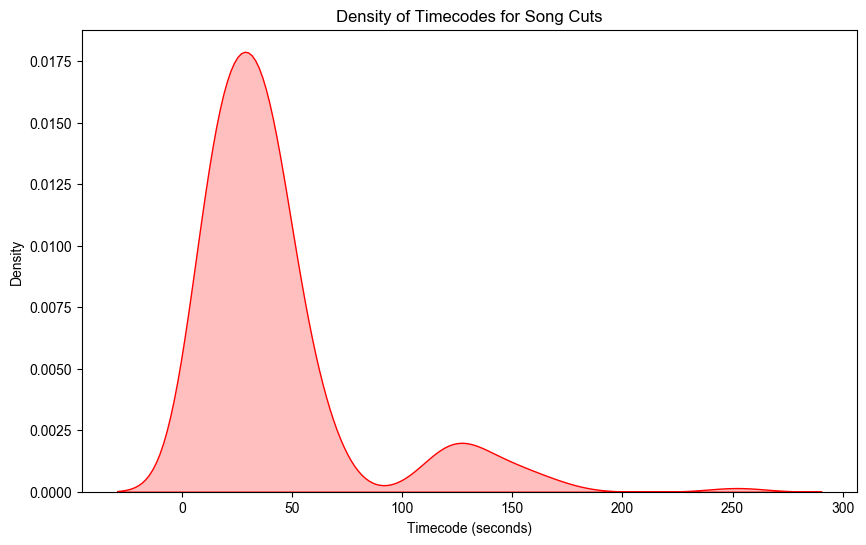

In [11]:
def timecode_to_seconds(timecode):
    # Split the timecode into minutes and seconds
    minutes, seconds = map(int, timecode.split(':'))
    # Convert the timecode to total seconds
    return minutes * 60 + seconds

# Apply the conversion function to each timecode
filtered_df['timecode'] = filtered_df['timecode'].apply(timecode_to_seconds)

plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_df['timecode'], fill=True, color="r")
plt.title('Density of Timecodes for Song Cuts')
plt.xlabel('Timecode (seconds)')
plt.ylabel('Density')
plt.show()

##### **c. Analyze The Release Date Of The Music Used By Trending Videos**
This section explores the density of timecodes for song cuts, providing insights into the distribution of song lengths. The KDE plot visualizes the distribution of timecodes (in seconds), allowing for the identification of common song durations.

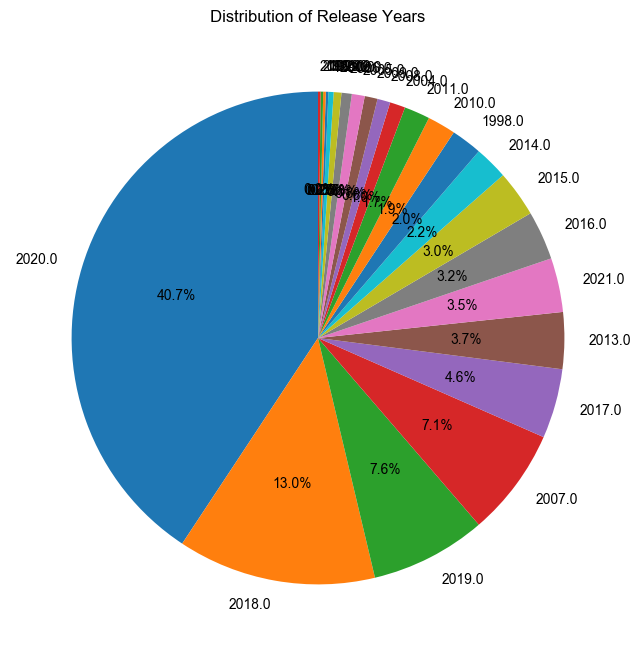

In [12]:
# Convert 'release date' to datetime if it's not already
merged_music_df['release_data'] = pd.to_datetime(merged_music_df['release_data'],errors='coerce')

# Extract the year from 'release date'
merged_music_df['release year'] = merged_music_df['release_data'].dt.year

year_counts = merged_music_df['release year'].value_counts()
plt.figure(figsize=(10, 8))
year_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Release Years')
plt.ylabel('')  # Hide the y-label as it's not needed for pie charts
plt.show()


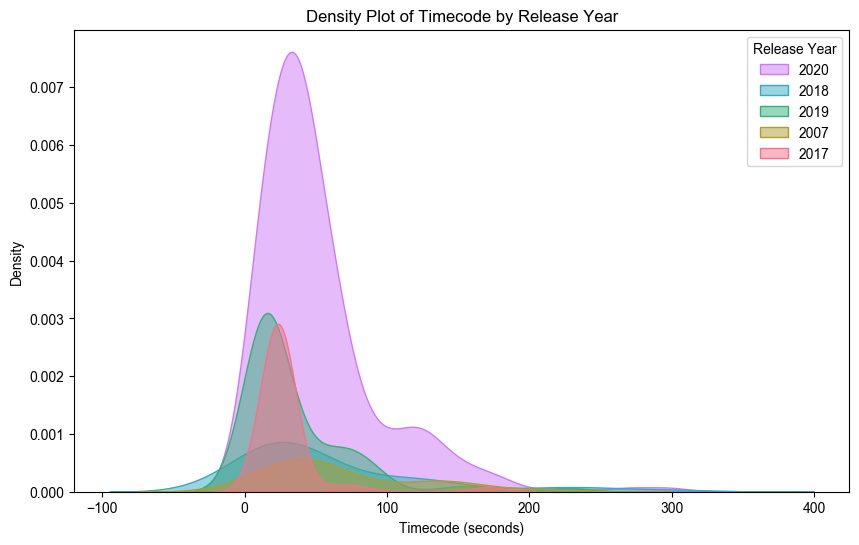

In [13]:
merged_music_df['timecode_seconds'] = merged_music_df['timecode'].apply(timecode_to_seconds)
yearly_timecode = merged_music_df.groupby('release year')['timecode_seconds'].median().reset_index()

# Define the top 5 years
top_years = [2020, 2018, 2019, 2007,2017]

# Filter the DataFrame to include only the top 5 years
filtered_df = merged_music_df[merged_music_df['release year'].isin(top_years)]
custom_palette = sns.color_palette("husl", len(top_years))
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_df, x='timecode_seconds', hue='release year', fill=True, alpha=0.5, legend=True, palette=custom_palette)
plt.xlabel('Timecode (seconds)')
plt.ylabel('Density')
plt.title('Density Plot of Timecode by Release Year')
plt.legend(title='Release Year', labels=top_years)
plt.show()

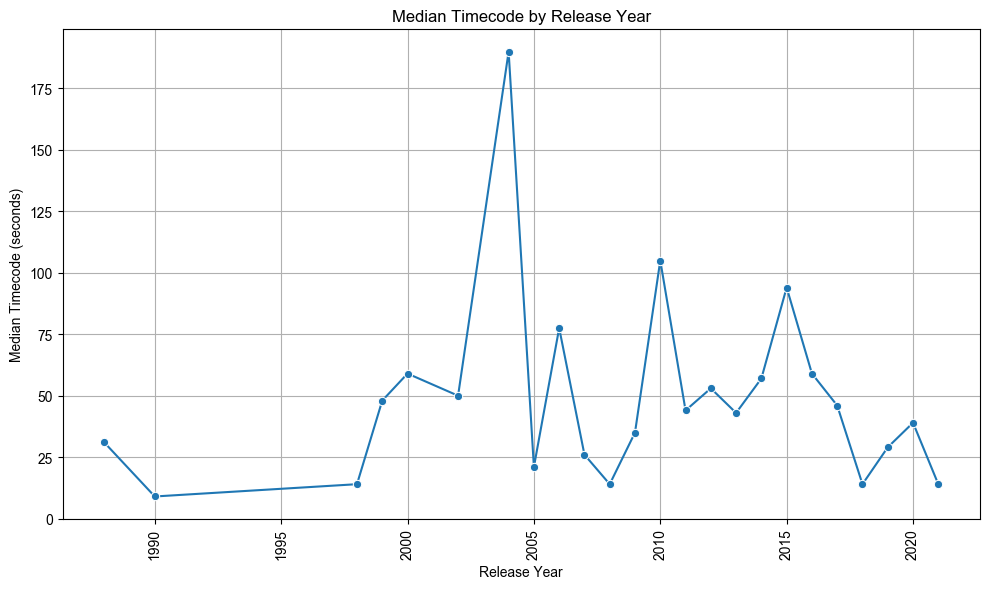

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_timecode, x='release year', y='timecode_seconds', marker='o')
plt.xlabel('Release Year')
plt.ylabel('Median Timecode (seconds)')
plt.title('Median Timecode by Release Year')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### **3. Author Related Analysis**

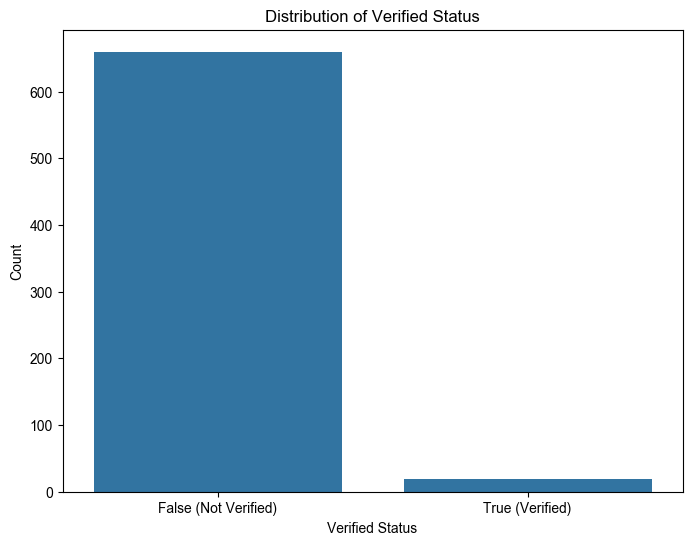

In [15]:
verified_counts = authors_df['verified'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=verified_counts.index.astype(str), y=verified_counts.values)  # Convert index to string for clarity

plt.title('Distribution of Verified Status')
plt.xlabel('Verified Status')
plt.ylabel('Count')
# Dynamically set x-tick labels based on the order in verified_counts
plt.xticks([0, 1], [f'{verified_counts.index[0]} (Not Verified)', f'{verified_counts.index[1]} (Verified)'])

plt.show()

authors_df = authors_df.rename(columns={'id': 'authors_id'})
combined_df = pd.concat([authors_df, merged_music_df], axis=1)

In [16]:
# Step 1: Filter combined_df for verified and unverified users
df_verified_users = combined_df[combined_df['verified'] == True]
df_unverified_users = combined_df[combined_df['verified'] == False]

# Step 2: Summarize music choices by year for verified users
# Assuming 'release_year' is the column in combined_df that indicates the release year of the songs
df_verified = df_verified_users.groupby('release year').size().reset_index(name='Song_Count')
df_verified['User_Type'] = 'Verified'

# Summarize music choices by year for unverified users
df_unverified = df_unverified_users.groupby('release year').size().reset_index(name='Song_Count')
df_unverified['User_Type'] = 'Unverified'

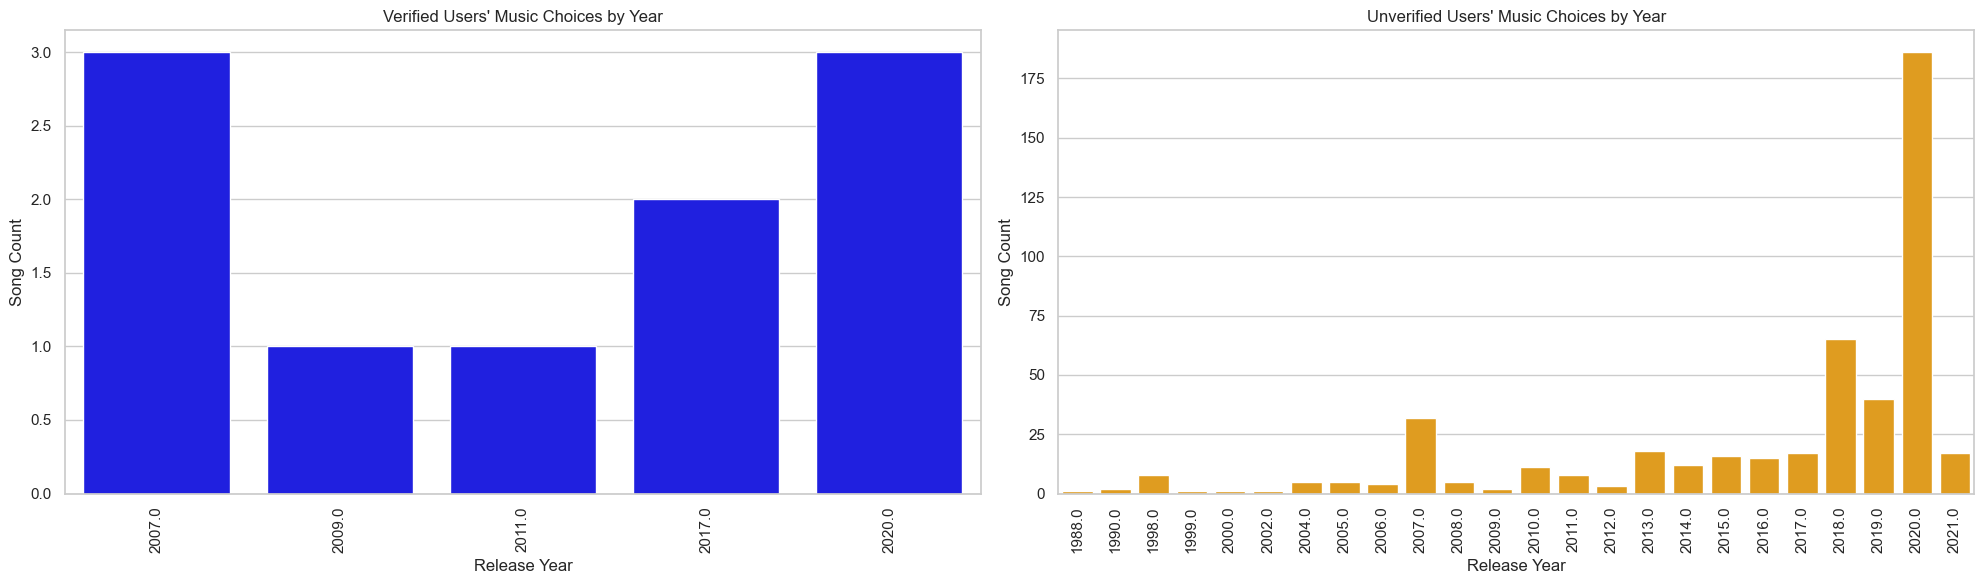

In [17]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plotting verified users' music choices by year
sns.barplot(ax=axes[0], data=df_verified, x='release year', y='Song_Count', color='blue')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Song Count')
axes[0].set_title("Verified Users' Music Choices by Year")
axes[0].tick_params(axis='x', rotation=90)

# Plotting unverified users' music choices by year
sns.barplot(ax=axes[1], data=df_unverified, x='release year', y='Song_Count', color='orange')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Song Count')
axes[1].set_title("Unverified Users' Music Choices by Year")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### **4. Video Related Analysis**

This section computes and displays the correlation coefficient between the duration of videos and various engagement metrics such as diggCount, shareCount, playCount, and commentCount. It will then fit a linear regression model to predict video duration based on engagement metrics and evaluates its performance using R-squared.The coefficients of the model are displayed, indicating the relative importance of each engagement metric in predicting video duration.

In [18]:
###### Video
def correlation_analysis(column_name):
    correlation_coefficient, _ = pearsonr(video_df['video_duration'], video_df[column_name])
    return correlation_coefficient

variables_to_compare = ['diggCount', 'shareCount', 'playCount', 'commentCount']

print("Correlation Coefficient between video_duration and Calculated by pearsonr:")
# Compute and print correlation coefficients
for variable in variables_to_compare:
    correlation_coefficient = correlation_analysis(variable)
    print(f"Correlation Coefficient (video_duration vs {variable}): {correlation_coefficient}")

X = video_df[['diggCount', 'shareCount', 'playCount', 'commentCount']]
y = video_df['video_duration']
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {metrics.r2_score(y_test, y_pred)}")
print(f"P-values: {model.coef_}")


Correlation Coefficient between video_duration and Calculated by pearsonr:
Correlation Coefficient (video_duration vs diggCount): 0.04328252676930378
Correlation Coefficient (video_duration vs shareCount): 0.06149484100612049
Correlation Coefficient (video_duration vs playCount): -0.01679653383827796
Correlation Coefficient (video_duration vs commentCount): 0.07684411112697243
Coefficients: [  4.86543998   6.11768616 -11.58879549   3.44878285]
Intercept: 18.52029718669578
R-squared: -0.003941415612633836
P-values: [  4.86543998   6.11768616 -11.58879549   3.44878285]


This scatter plots visualize the relationship between video duration and each engagement metric, providing insights into how video length influences engagement.

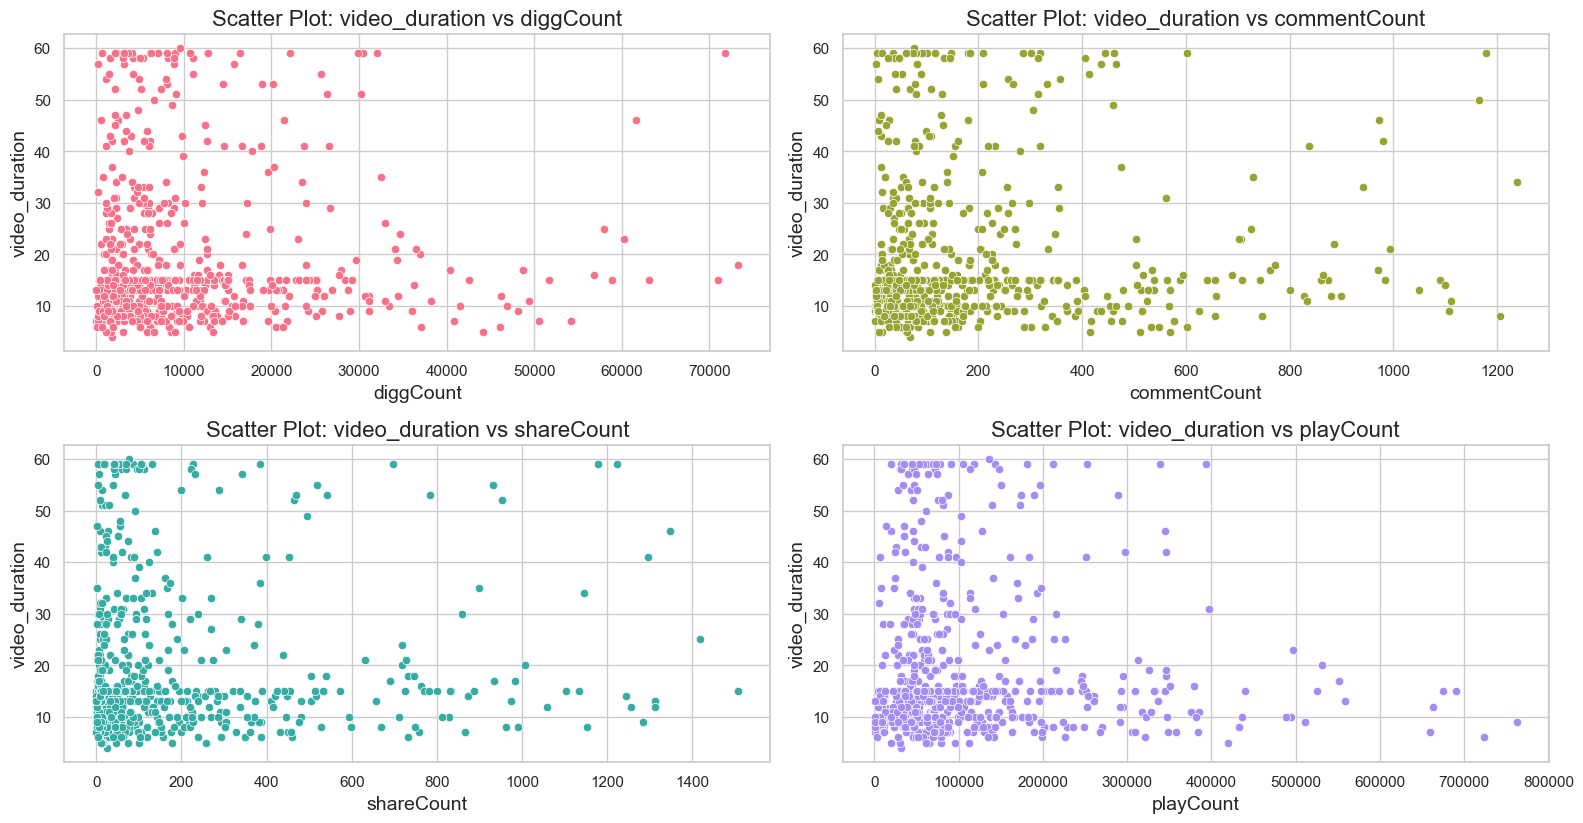

In [19]:
num_cols = ["diggCount", "commentCount", "shareCount", "playCount"]
colors = sns.color_palette('husl', len(num_cols))

plt.figure(figsize=(16, 12))

for i, col in enumerate(num_cols, start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=col, y='video_duration', data=video_df, color=colors[i-1])
    plt.title(f'Scatter Plot: video_duration vs {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('video_duration', fontsize=14) 
    
plt.tight_layout()
plt.show()

This heatmap visualizes the correlation matrix between video duration and engagement metrics, offering a comprehensive view of their relationships.

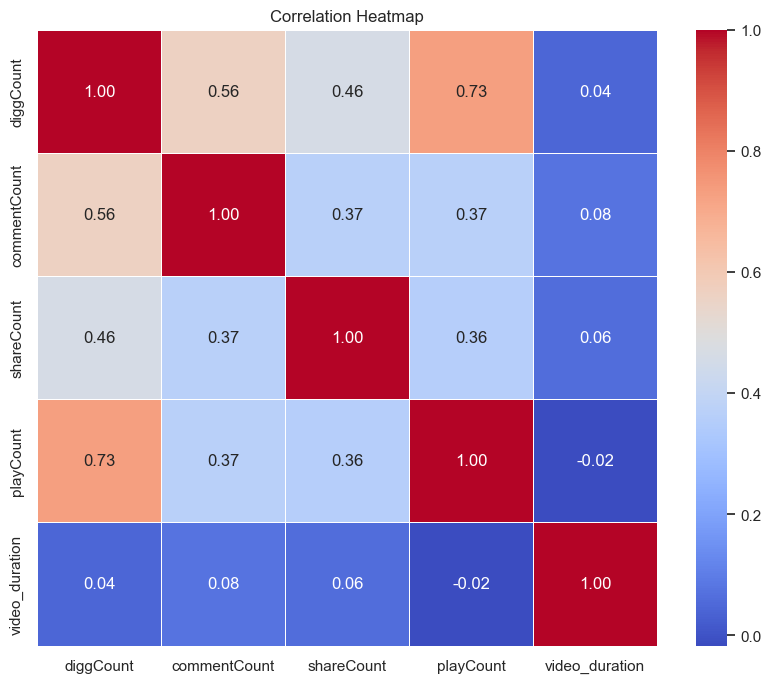

In [20]:
# Correlation heatmap
video_new_df = video_df[["diggCount", "commentCount", "shareCount", "playCount", "video_duration"]]
plt.figure(figsize=(10, 8))
correlation_matrix = video_new_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### **5. Test Related Analysis**

This part calculates the probability distribution of hashtag categories (e.g., diggCountCategory, shareCountCategory) based on engagement counts. It identifies hashtags with very high and very low engagement counts within each category.

In [21]:
###### Text
def calculate_probability(text_df, count, category):
    text_df = text_df[['hashtag', count, category]].sort_values(by='hashtag')

    # Group the data by hashtag and category
    group_text_df = text_df.groupby(['hashtag', category]).size().reset_index(name='count')
    total_count_per_hashtag = text_df.groupby(['hashtag', category])[count].mean().reset_index(name='mean_' + count)
    merged_df = pd.merge(group_text_df, total_count_per_hashtag, on=['hashtag', category])

    # The probaility of 'very low', 'low', 'medium', 'high', 'very high' over total number of catagory
    merged_df['probability'] = merged_df.groupby('hashtag')['count'].transform(lambda x: x / x.sum())
    
    # Filter out records that have more than 1 occuring and > 0.5 probability of each catagory over total cattagory
    filtered_text_df = merged_df[(merged_df['count'] > 1) & (merged_df['probability'] > 0.5)]

    text_very_high_df = filtered_text_df[filtered_text_df[category] == 'very high']
    text_very_low_df = filtered_text_df[filtered_text_df[category] == 'very low']
    return text_df, text_very_high_df.head(10), text_very_low_df.head(10)

digg_count_cat_df, digg_count_cat_very_high, digg_count_cat_very_low = calculate_probability(text_df, 'diggCount', 'diggCountCategory')
share_count_cat_df, share_count_cat_very_high, share_count_cat_very_low = calculate_probability(text_df, 'shareCount', 'shareCountCategory')
play_count_cat_df, play_count_cat_very_high, play_count_cat_very_low = calculate_probability(text_df, 'playCount', 'playCountCategory')
comment_count_cat_df, comment_count_cat_very_high, comment_count_cat_very_low = calculate_probability(text_df, 'commentCount', 'commentCountCategory')

This word cloud visualizes the most frequent hashtags, providing insights into popular topics or themes.

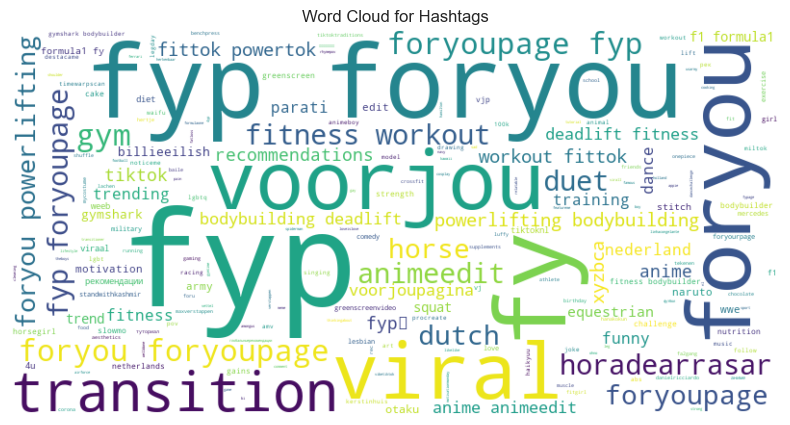

In [24]:
all_hashtags = ' '.join(text_df['hashtag'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_hashtags)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hashtags')
plt.show()

These Bar charts showcase the top hashtags with very high engagement counts for each category, allowing for a deeper understanding of popular topics on the platform.

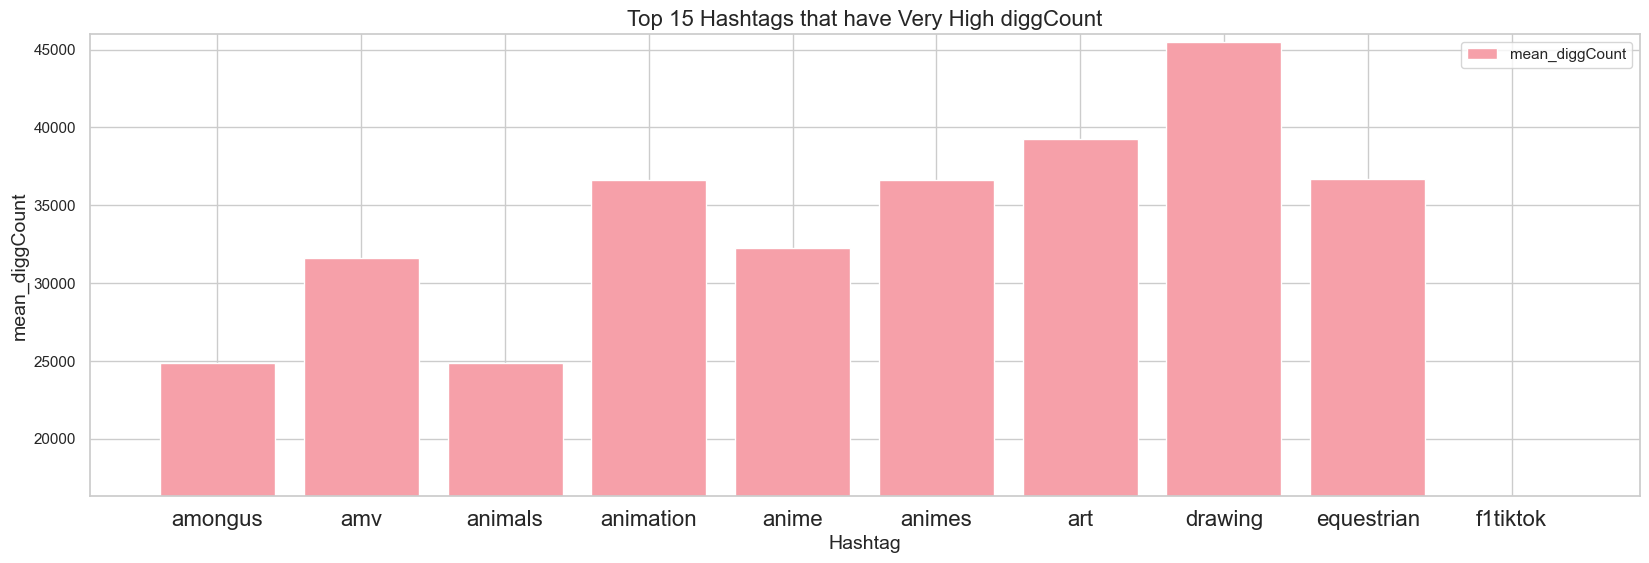

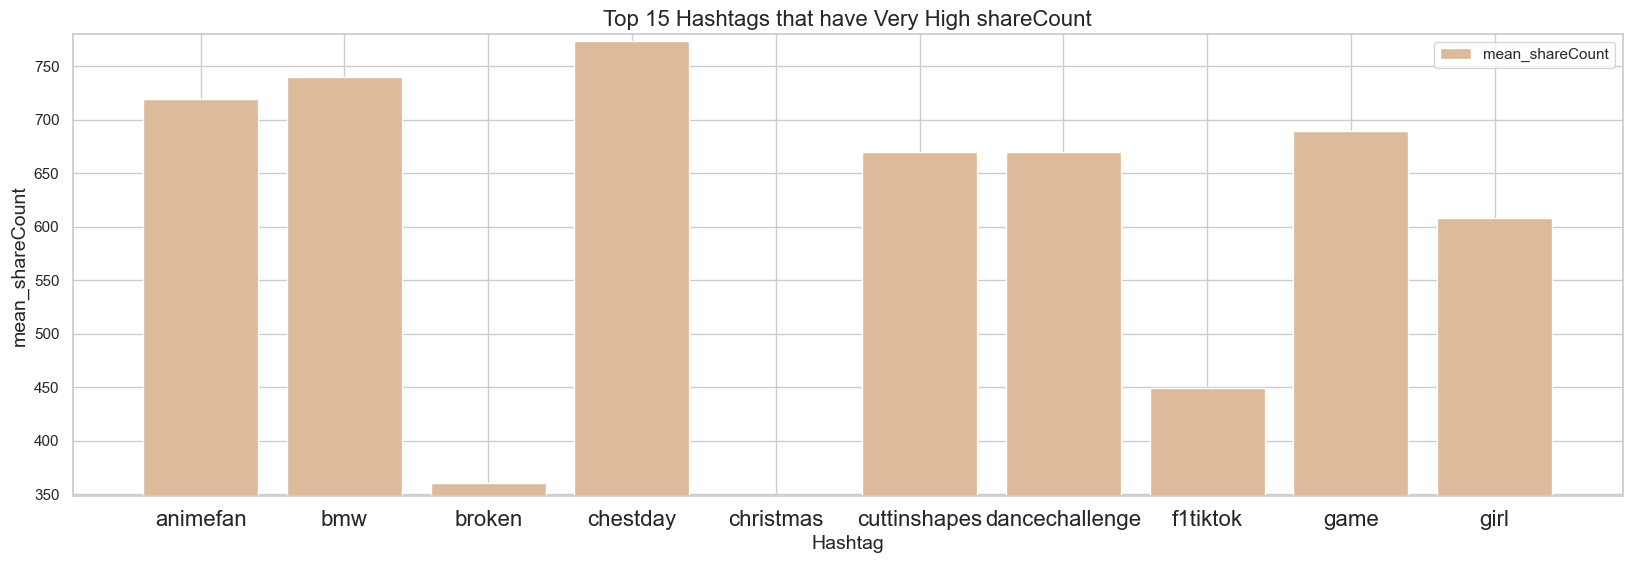

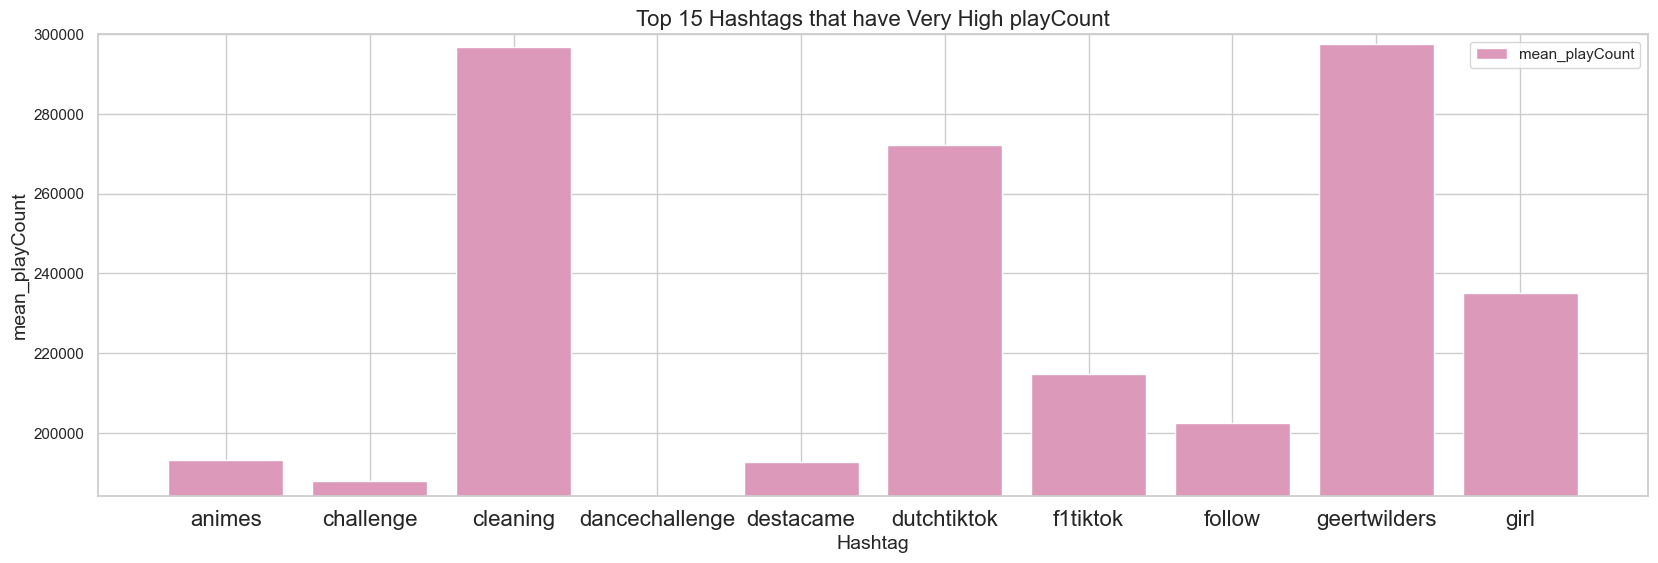

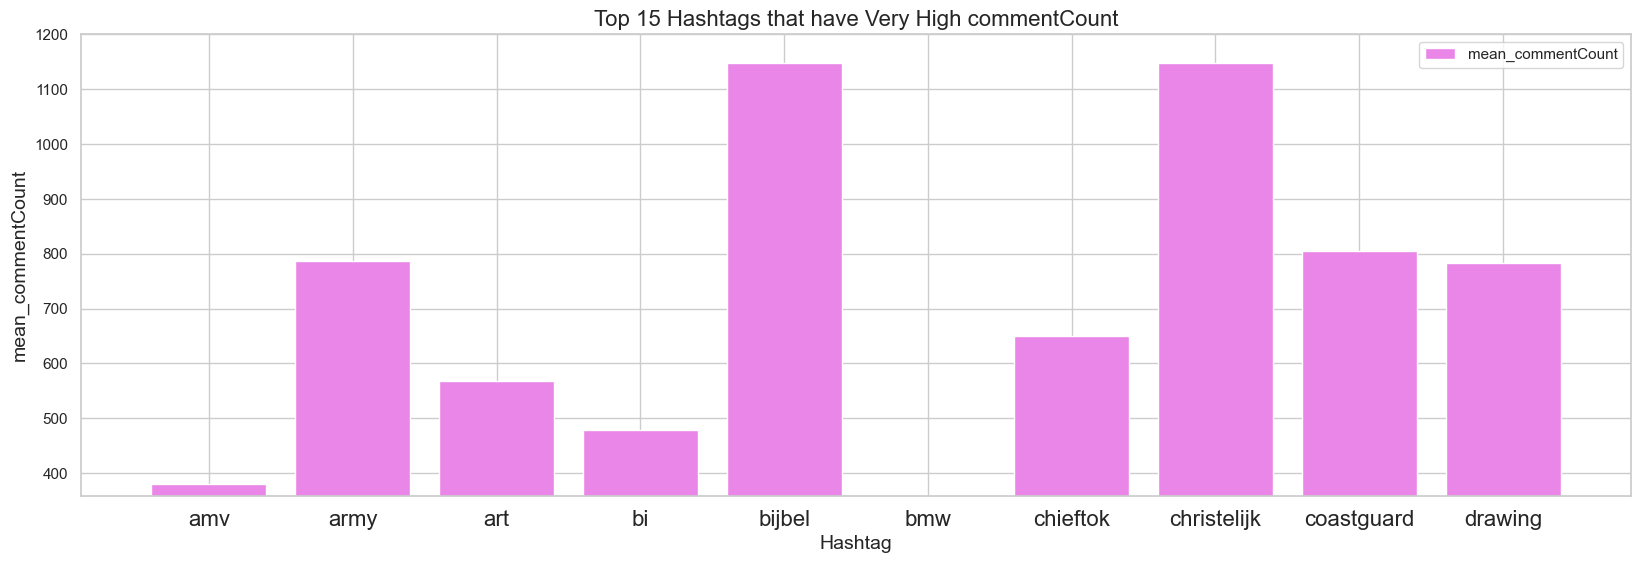

In [25]:

def getBarChart(df, mean_count, count_name, min_val, max_val, color='blue'):
    fig, ax = plt.subplots(figsize=(20, 6))
    bar_width = 0.35
    ax.bar(df['hashtag'], df[mean_count], color=color, label=mean_count)
    ax.set_xlabel('Hashtag', fontsize=14)
    ax.set_ylabel(mean_count, fontsize=14)
    ax.set_title('Top 15 Hashtags that have ' + count_name, fontsize=16)
    ax.legend()
    plt.xticks(fontsize=16)
    num_digits = len(str(max_val))
    nearest_multiple = 10 ** (num_digits - 4)
    ax.set_ylim(math.floor(min_val), int(math.ceil(max_val / float(nearest_multiple))) * nearest_multiple)
    plt.show()

getBarChart(digg_count_cat_very_high, 'mean_diggCount', 'Very High diggCount', digg_count_cat_very_high['mean_diggCount'].min(), digg_count_cat_very_high['mean_diggCount'].max(), color='#f6a0a9')
getBarChart(share_count_cat_very_high, 'mean_shareCount', 'Very High shareCount', share_count_cat_very_high['mean_shareCount'].min(), share_count_cat_very_high['mean_shareCount'].max(), color='#ddba99')
getBarChart(play_count_cat_very_high, 'mean_playCount', 'Very High playCount', play_count_cat_very_high['mean_playCount'].min(), play_count_cat_very_high['mean_playCount'].max(), color='#dd99ba')
getBarChart(comment_count_cat_very_high, 'mean_commentCount', 'Very High commentCount', comment_count_cat_very_high['mean_commentCount'].min(), comment_count_cat_very_high['mean_commentCount'].max(), color='#ea86e8')
